In [17]:
import sys, os
from pathlib import Path
import pandas as pd

# To include CVR & formation_energy packages in this directory
current_dir = Path.cwd()
relative_path = current_dir / '..' / '..'
sys.path.append(str(relative_path))


In [3]:
import model_trainer

## Initializing variables

In [6]:
args = dict(
    notebook_filename='model7_training.ipynb',
    result_dir=Path('results', f'model7_training'),
    gpu_n='0',
    epochs=500,
    random_seed=0,
    box=model_trainer.CVR.BoxImage(box_size=70//4, n_bins=128//4),
    channels=['atomic_number', 'group', 'period'],
    filling='fill-cut',
    y='formation_energy_per_atom',
    batch_size=32,  
    random_rotation=True,
)

#############################

trainer = model_trainer.ModelTrainer(**args)
trainer.prepare_system()
pass

Executable     :  /Users/ali/mambaforge/envs/py38/bin/python
Results        :  results/model7_training


In [8]:
from keras import layers
from keras.models import Model
from formation_energy.model import convolutional_block, residual_block

mul = 0.5

input_shape = tuple([trainer.params['box'].n_bins]*3 + [len(trainer.params['channels'])])
inputs = layers.Input(shape=input_shape)
X = inputs # Should not be removed

X = convolutional_block(X, num_filters=32, kernel_size=3, activation='relu')

X = residual_block(X, n_conv_blocks=2, n_filters=32, kernel_size=3, activation='relu', merge_mode='add')
X = residual_block(X, n_conv_blocks=2, n_filters=32, kernel_size=3, activation='relu', merge_mode='concat')

X = layers.AveragePooling3D()(X)

X = residual_block(X, n_conv_blocks=2, n_filters=64, kernel_size=3, activation='relu', merge_mode='add')
X = residual_block(X, n_conv_blocks=2, n_filters=64, kernel_size=3, activation='relu', merge_mode='add')
X = residual_block(X, n_conv_blocks=2, n_filters=64, kernel_size=3, activation='relu', merge_mode='concat')


X = layers.AveragePooling3D()(X)

X = residual_block(X, n_conv_blocks=2, n_filters=128, kernel_size=3, activation='relu', merge_mode='add')
X = residual_block(X, n_conv_blocks=2, n_filters=128, kernel_size=3, activation='relu', merge_mode='add')

X = layers.AveragePooling3D()(X)
X = layers.Flatten()(X)

X = layers.Dense(16)(X)
X = layers.Dense(16)(X)
X = layers.Dense(1)(X)

outputs = X
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_absolute_error']
              )

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d_15 (Conv3D)             (None, 32, 32, 32,   2624        ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 activation_15 (Activation)     (None, 32, 32, 32,   0           ['conv3d_15[0][0]']              
                                32)                                                         

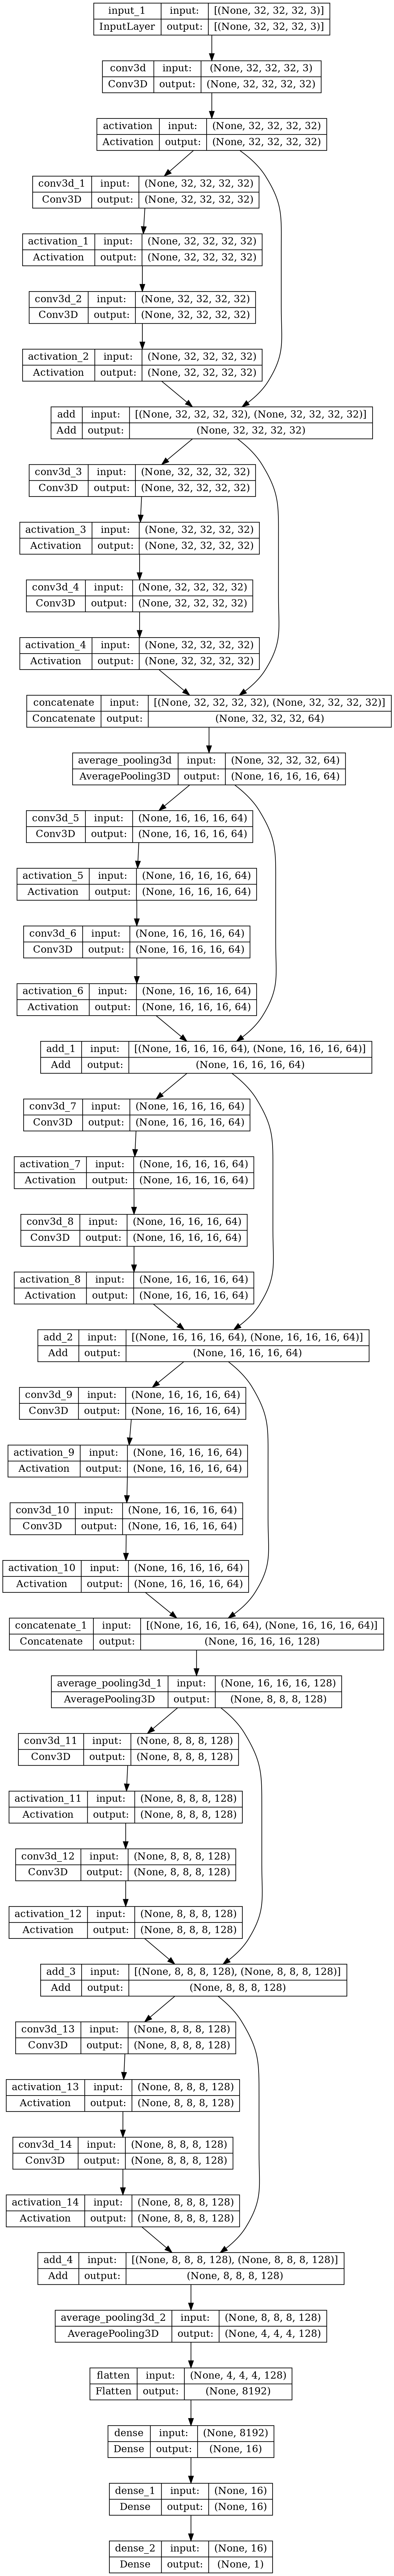

In [6]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file=trainer.result_dir/'model.png', dpi=200)

## Preparing data set

In [3]:
data_path = 'path_to_data'
filename = Path(data_path, 'cif_files.pkl')
import pickle
with open(filename, 'rb') as f:
    data = pickle.load(f)
df_train = data['train']
df_test = data['test']
df_dev = data['dev']

# Preparing the image generators
generators = model_trainer.DataPreparation(
    data={
        'train': df_train, 
        'test': df_test, 
        'dev.': df_dev
    },
    **trainer.params,
).prepare()
train_gen, test_gen, dev_gen = generators['train'], generators['test'], generators['dev.']

Loading the CIF files ...
Done!
Dataset: train
Checking the image requirements


100%|██████████████████████████████████████████████████████████████████████████████| 83620/83620 [01:07<00:00, 1235.44it/s]


9175 images did not meet the requirements and were removed from the train set.
Preparing the point clouds for data set: train


100%|███████████████████████████████████████████████████████████████████████████████| 74445/74445 [08:11<00:00, 151.39it/s]


Point clouds for data set: train are ready
Preparing the image generators ...
Stats          : Tot. samples=74,445  [Pos.=     0 - Neg.=     0(0.0%)]
Dataset: test
Checking the image requirements


100%|███████████████████████████████████████████████████████████████████████████████| 27874/27874 [02:01<00:00, 229.73it/s]


3021 images did not meet the requirements and were removed from the test set.
Preparing the point clouds for data set: test


100%|███████████████████████████████████████████████████████████████████████████████| 24853/24853 [03:06<00:00, 133.14it/s]


Point clouds for data set: test are ready
Preparing the image generators ...
Stats          : Tot. samples=24,853  [Pos.=     0 - Neg.=     0(0.0%)]
Dataset: dev.
Checking the image requirements


100%|██████████████████████████████████████████████████████████████████████████████| 27873/27873 [00:26<00:00, 1062.89it/s]


3149 images did not meet the requirements and were removed from the dev. set.
Preparing the point clouds for data set: dev.


100%|███████████████████████████████████████████████████████████████████████████████| 24724/24724 [02:34<00:00, 159.95it/s]


Point clouds for data set: dev. are ready
Preparing the image generators ...
Stats          : Tot. samples=24,724  [Pos.=     0 - Neg.=     0(0.0%)]
Time to prepare the image generators: 0:17:46


In [10]:
from run import get_callbacks
callbacks = get_callbacks(trainer.result_dir)

## Training

In [10]:
# trainer.train_model(model, train_generator, test_generator, callbacks)
trainer.train_model(model, train_gen, dev_gen, callbacks)

Model and dataset are compatible in shapes.
Epoch 1/500
2327/2327 [==============================] - 3296s 1s/step - loss: 0.4146 - mean_absolute_error: 0.4542 - val_loss: 0.2835 - val_mean_absolute_error: 0.4035
Epoch 2/500
2327/2327 [==============================] - 3278s 1s/step - loss: 0.2354 - mean_absolute_error: 0.3285 - val_loss: 0.1805 - val_mean_absolute_error: 0.3164
Epoch 3/500
2327/2327 [==============================] - 3232s 1s/step - loss: 0.1231 - mean_absolute_error: 0.2473 - val_loss: 0.1530 - val_mean_absolute_error: 0.2961
Epoch 4/500
2327/2327 [==============================] - 3221s 1s/step - loss: 0.0964 - mean_absolute_error: 0.2187 - val_loss: 0.0748 - val_mean_absolute_error: 0.1902
Epoch 5/500
2327/2327 [==============================] - 3231s 1s/step - loss: 0.0704 - mean_absolute_error: 0.1885 - val_loss: 0.0847 - val_mean_absolute_error: 0.2156
Epoch 6/500
2327/2327 [==============================] - 2414s 1s/step - loss: 0.0573 - mean_absolute_error: 0.

### History Plots (Loss & Accuracy)

Plot saved at: results/train_improvement_9/train_15lm-6sk-t1(model7-all-mp)/loss.png
Plot saved at: results/train_improvement_9/train_15lm-6sk-t1(model7-all-mp)/loss.pdf


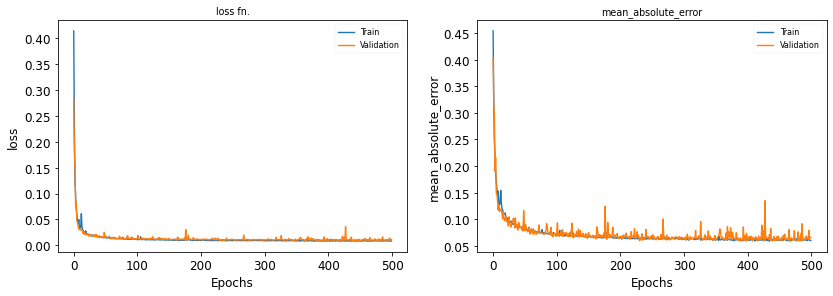

In [11]:
trainer.plot_loss()

In [15]:
history.sort_values('val_mean_absolute_error').head(10)

,epoch,loss,mean_absolute_error,val_loss,val_mean_absolute_error
466,467,0.008411,0.060633,0.009475,0.059029
484,485,0.008581,0.060976,0.009610,0.059084
397,398,0.008253,0.060127,0.009548,0.059089
439,440,0.009089,0.062265,0.009689,0.059130
407,408,0.008145,0.059828,0.009558,0.059206
387,388,0.008392,0.060921,0.009582,0.059209
477,478,0.009777,0.064029,0.009494,0.059244
425,426,0.008701,0.061114,0.009747,0.059358
415,416,0.008236,0.060142,0.009521,0.059409
480,481,0.008459,0.060497,0.009310,0.059590


## Evaluation

In [4]:
history = pd.read_csv(os.path.join(trainer.result_dir, 'history.csv'))
best_epoch_num = history.sort_values('val_mean_absolute_error')['epoch'].iloc[0]
best_epoch_num
history

,epoch,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,1,0.4146,0.4542,0.2835,0.4035
1,2,0.2354,0.3285,0.1805,0.3164
2,3,0.1231,0.2473,0.1530,0.2961
3,4,0.0964,0.2187,0.0748,0.1902
4,5,0.0704,0.1885,0.0847,0.2156
...,...,...,...,...,...
495,496,0.0088,0.0614,0.0101,0.0622
496,497,0.0085,0.0612,0.0144,0.0791
497,498,0.0085,0.0614,0.0103,0.0639
498,499,0.0084,0.0601,0.0107,0.0661


## Evaluation (Ensemble 1)

In [6]:
# Picking Epock 467 as the main epoch that has the best val error as well
history = pd.read_csv(os.path.join(trainer.result_dir, 'history.csv'))
best_epoch_num = history.sort_values('val_mean_absolute_error')['epoch'].iloc[0]
model_trained = trainer.load_model(epoch=best_epoch_num)
ev = trainer.evaluate(model_trained, generators.values())

Predicting train ...
2327/2327 [==============================] - 2546s 1s/step
Predicting test ...
777/777 [==============================] - 843s 1s/step
Predicting dev. ...
773/773 [==============================] - 842s 1s/step
End of evaluations. Run time: 1:11:44


Plot saved at: results/train_improvement_9/train_15lm-6sk-t1(model7-all-mp)/train_set_parity.png
Plot saved at: results/train_improvement_9/train_15lm-6sk-t1(model7-all-mp)/train_set_parity.pdf


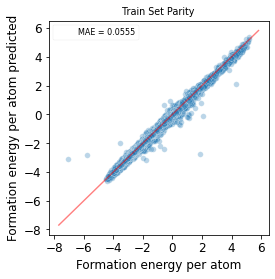

Plot saved at: results/train_improvement_9/train_15lm-6sk-t1(model7-all-mp)/test_set_parity.png
Plot saved at: results/train_improvement_9/train_15lm-6sk-t1(model7-all-mp)/test_set_parity.pdf


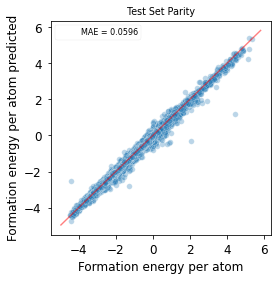

Plot saved at: results/train_improvement_9/train_15lm-6sk-t1(model7-all-mp)/dev._set_parity.png
Plot saved at: results/train_improvement_9/train_15lm-6sk-t1(model7-all-mp)/dev._set_parity.pdf


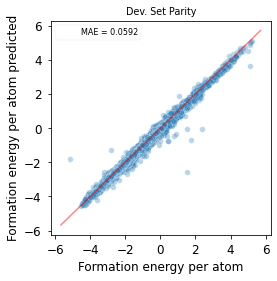

In [7]:
trainer.parity_plot(df=ev, save_plots=True)
pass

## Evaluation (Ensemble 50)

In [ ]:
model_trained = trainer.load_model()
ev = trainer.evaluate(model_trained, generators.values())

Predicting train ...
 12978/116350 [==>...........................] - ETA: 29:16:23

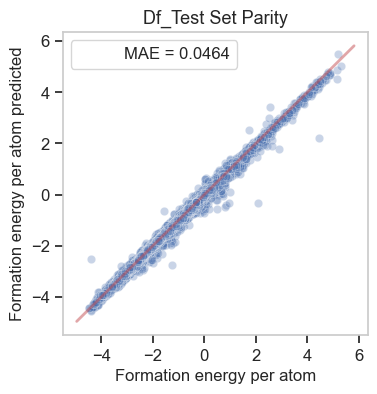

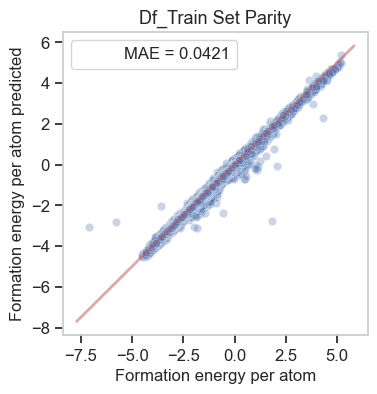

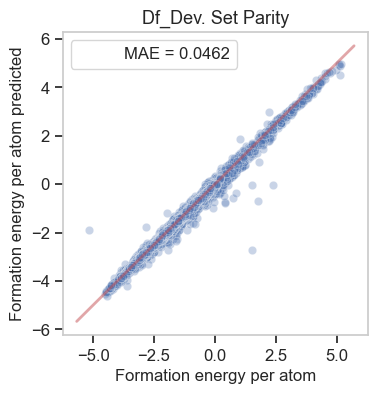

In [19]:
trainer.parity_plot(df=ev, save_plots=True)
pass

## Visualization

In [14]:
from utility import util_mp, crystal_image_tools, cnn_visualizer

model = trainer.load_model()
atoms = util_mp.mpr.get_atoms('mp-1102417')[0]
img = crystal_image_tools.ThreeDImage(
    atoms,
    box=trainer.params['box'],
    channels=trainer.params['channels'],
    filling=trainer.params['filling'],
)
img

3D Image - ID: mp-1102417

### Visualization: Weights

In [15]:
# Selecting the layers to visualize

desired_layers = cnn_visualizer.model_layers_outputs(
    model, 
    layer_names=['conv', 'dense'], 
    layer_indices=None, 
    verbose=True,
    return_layers=True,
)

Desired layers:
conv3d                                   	 (None, 32, 32, 32, 32)
conv3d_1                                 	 (None, 32, 32, 32, 32)
conv3d_2                                 	 (None, 32, 32, 32, 32)
conv3d_3                                 	 (None, 32, 32, 32, 32)
conv3d_4                                 	 (None, 32, 32, 32, 32)
conv3d_5                                 	 (None, 16, 16, 16, 64)
conv3d_6                                 	 (None, 16, 16, 16, 64)
conv3d_7                                 	 (None, 16, 16, 16, 64)
conv3d_8                                 	 (None, 16, 16, 16, 64)
conv3d_9                                 	 (None, 16, 16, 16, 64)
conv3d_10                                	 (None, 16, 16, 16, 64)
conv3d_11                                	 (None, 8, 8, 8, 128)
conv3d_12                                	 (None, 8, 8, 8, 128)
conv3d_13                                	 (None, 8, 8, 8, 128)
conv3d_14                                	 (None, 8, 8, 8, 128)
de

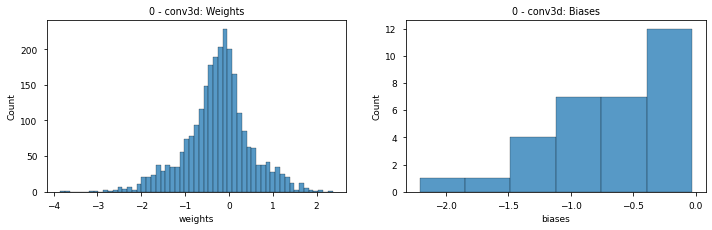

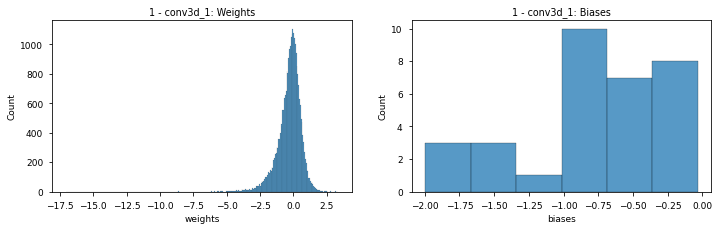

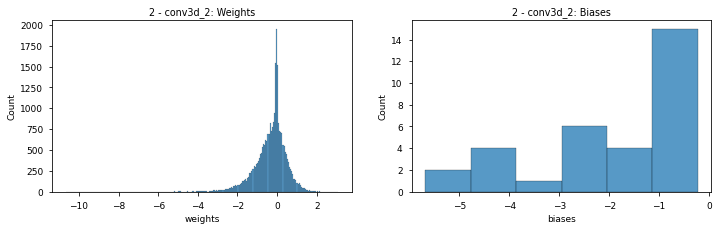

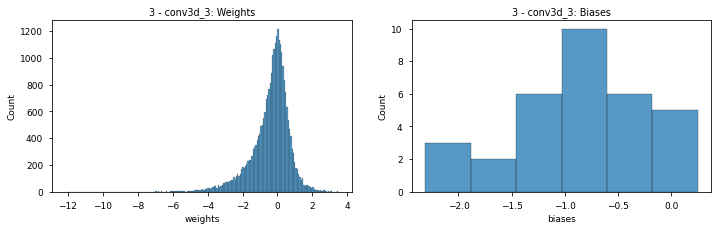

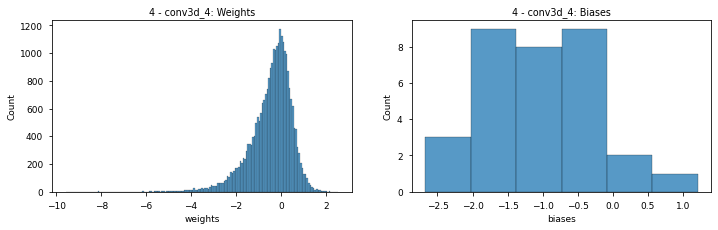

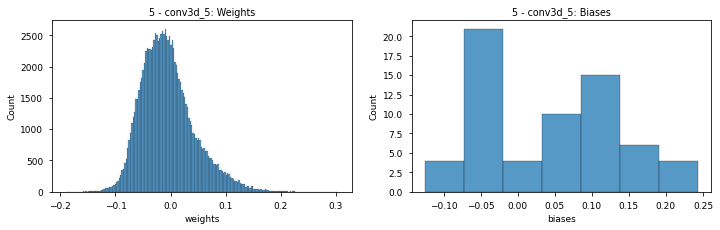

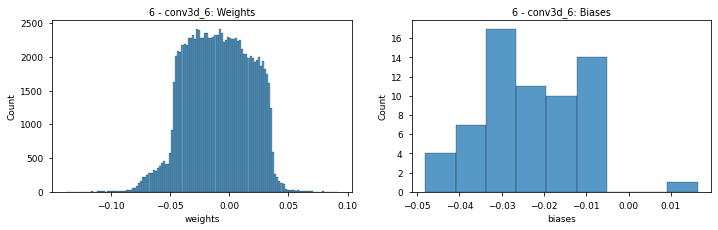

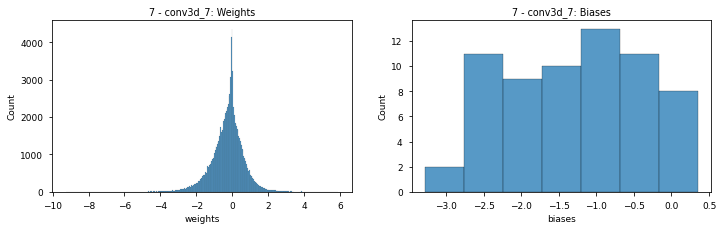

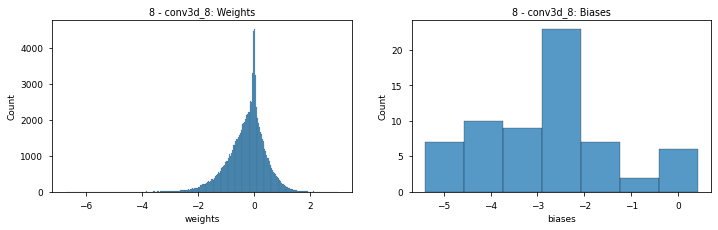

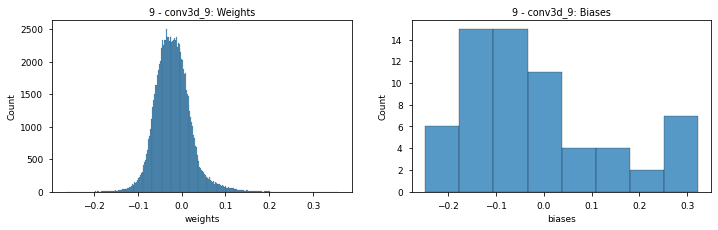

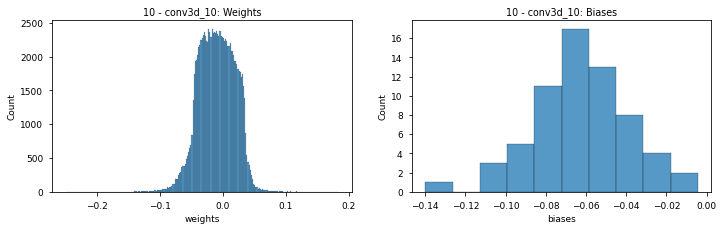

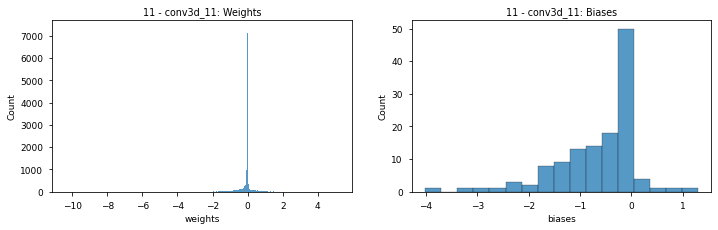

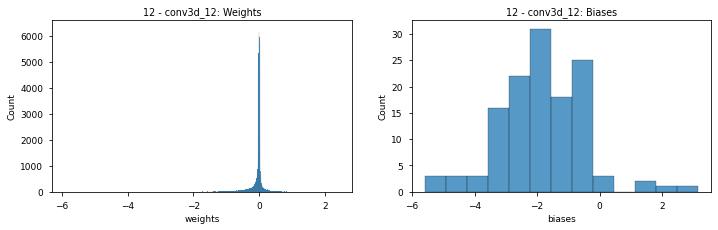

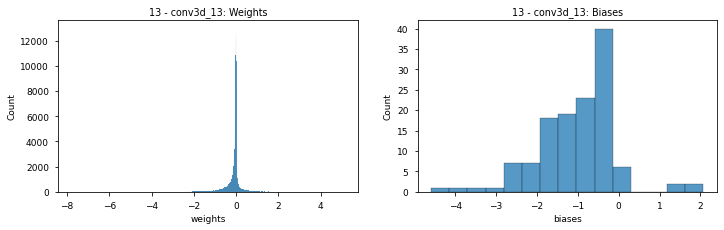

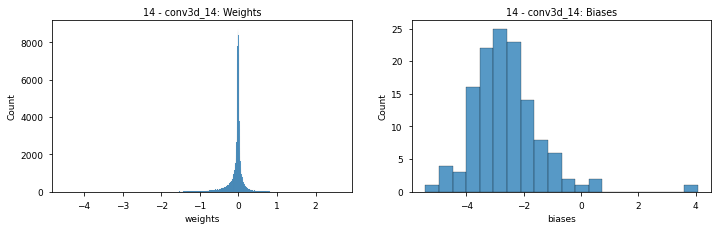

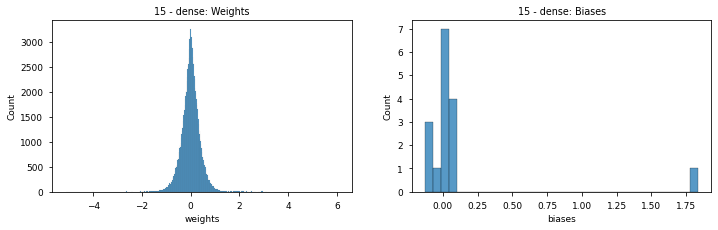

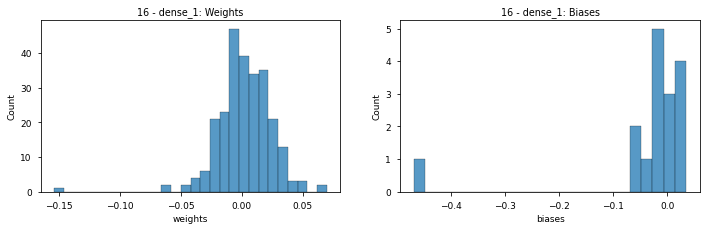

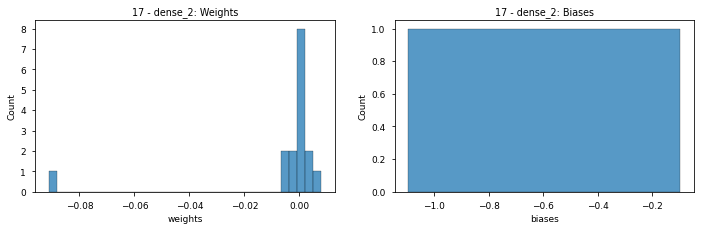

In [16]:
fig, display_list = cnn_visualizer.visualize_model_weights(desired_layers)
# [display(d) for d in display_list]
pass

### Visualization: Sample

In [17]:
# Selecting the layers to visualize

model_layers = cnn_visualizer.model_layers_outputs(
    model, 
    layer_names=['all'], 
    layer_indices=None, 
    verbose=True
)

Desired layers:
input_1                                  	 (None, 32, 32, 32, 3)
conv3d                                   	 (None, 32, 32, 32, 32)
activation                               	 (None, 32, 32, 32, 32)
conv3d_1                                 	 (None, 32, 32, 32, 32)
activation_1                             	 (None, 32, 32, 32, 32)
conv3d_2                                 	 (None, 32, 32, 32, 32)
activation_2                             	 (None, 32, 32, 32, 32)
add                                      	 (None, 32, 32, 32, 32)
conv3d_3                                 	 (None, 32, 32, 32, 32)
activation_3                             	 (None, 32, 32, 32, 32)
conv3d_4                                 	 (None, 32, 32, 32, 32)
activation_4                             	 (None, 32, 32, 32, 32)
concatenate                              	 (None, 32, 32, 32, 64)
average_pooling3d                        	 (None, 16, 16, 16, 64)
conv3d_5                                 	 (None, 16, 16, 16,

In [18]:
figs,display_list = cnn_visualizer.visualize_sample(
    model_layers, 
    img.get_image()[np.newaxis, ...], 
    save_path=trainer.result_dir/'visualization/', 
    return_display_list=True, 
    image_slice_figure=True,
    voxel_figure=False
)
# [display(d) for d in display_list]
# pass

1/1 [==============================] - 0s 272ms/step


## Saving the notebook and release GPU

In [19]:
trainer.end_training()

End of the training. Run time: 12 days, 0:21:40 


Releasing the allocated GPU(s)
Storing the *.py files in a tar file.
Saving the notebook



/bin/sh: 1: Syntax error: "(" unexpected

